### DATA 643 Project 2: Content-Based and Collaborative Filtering
_Nathan, Angas, Pavan_

The goal of this assignment is for you to try out different ways of implementing and configuring a recommender, and to evaluate your different approaches.

For assignment 2, start with an existing dataset of user-item ratings, such as our toy books dataset, MovieLens, Jester [http://eigentaste.berkeley.edu/dataset/] or another dataset of your choosing. Implement at least two of these recommendation algorithms:
- Content-Based Filtering
- User-User Collaborative Filtering
- Item-Item Collaborative Filtering

#### Dataset

We will be using [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/). GroupLens Research maintains movie rating data sets collected from the website [MovieLens](http://movielens.org). The datasets were collected over various periods of time, depending on the size of the set. For the scope of the project, we will be using _small dataset_ that contains 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

#### Content-Based Filtering

The goal is to provide movie recommendations for the user based on their viewing pattern. We assume that a viewer has fully watched and rated the movie based on its content. Another assumption is viewer wants to watch movies with similar content that he/she rated above average. Therefore we want to build a content-based recommender that is going to recommend new similar movies based on the users historical viewing behavior.

To achieve accurate and useful recommendations we will be using _Term Frequency Inverse Document Frequency(tfidf)_, a popular technique to evaluate how important a word is to a document in a collection or corpus. In our case, a movie is classified into a various genre, 

Example: Movie _Toy Story (1995)_ is classified in _adventure, animation, children, comedy, and fantasy_ 

This movie may be recommended for users who want to watch _adventure_ or to a family with _childern_. In short, it can be recommended to users with various tastes.

From the dataset we have identified movies may be classified into 22 different categories,

_action, adventure, western, animation, romance, musical, sci-fi, thriller, drama, documentary, horror, comedy, children, film-noir, mystery, war, fantasy, crime, no, listed, genres, imax_

#### Similarity

We will be using three different measures to identify the similarity between movies _Cosine similarity_, _Pearson's Correlation Coefficient_ and _Euclidean Distance_.

In [312]:
#Load libraries and functions
import numpy as np
import pandas as pd
import re #import regular expression package
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [313]:
#Define functions

def tokenize(movies):
    """
    movies dataset has column genres contain categorical information
    Example: Toy Story (1995) is classified as Adventure|Animation|Children|Comedy|Fantasy
    Lets extract data the column and convert to columns
    """
    def tokenize_string(my_string):
        return re.findall('[\w\-]+', my_string.lower())
    
    tokenlist=[]
    for index,row in movies.iterrows():
        tokenlist.append(tokenize_string(row.genres))
    movies['tokens']=tokenlist
    return movies

def tokensToColumns(movies):
    doclist = movies['tokens'].tolist()

    """ 
    Loop through each token and generate unique list 
    Goal is to assign all 22 categories to each movie
    If movie falls in the category it will get 1 otherwise 0
    """
    categories = list(set(i for s in doclist for i in s))
    df = pd.DataFrame()
    #Loop through dataframe and seperate tokens into columns
    for index,row in movies.iterrows():
        #tokens of the row
        cat = row['tokens']
        #tokens do not match entire list
        missCat = list(set(categories) - set(cat))
        #assign zero to missmatch
        missCat = { missmatch:0 for missmatch in missCat }
        #assign 1 to matches
        movieCat = { missmatch:1 for missmatch in cat }
        #concat both lists
        movieCat.update(missCat)
        #Convert to dict
        #movieCat = dict(sorted(movieCat.items()))
        movieCat = dict(movieCat.items())
        #create data row
        data = {'movieId':row.movieId, 'title': row.title, 'termCount': len(cat)}
        #add categories
        data.update(movieCat)
        #write to dataframe
        df = df.append(data, ignore_index=True)
    
    #rearrange the columns
    cols = df.columns.tolist()
    cols.remove('movieId')
    cols.remove('title')
    cols.remove('termCount')
    cols.insert(0, 'termCount')
    cols.insert(0, 'title')
    cols.insert(0, 'movieId')
    df = df[cols]
    return categories, df

def movieRecommendation(ratings, movies, similarityDf, algo):
    #similarityDf = movies_cosineSim
    #algo = 'cosine'
    #user = 1
    #Declare dataframe that will returned as output
    user_Rec = pd.DataFrame()
    
    #Get unique userlist
    usersDf = list(ratings.userId.unique())
    
    #Loop through each user and based on viewing pattern assign un-watched movies similar to watched movies
    for i, user in enumerate(usersDf):
        
        #Get average user rating
        user_AvgRating = ratings[ratings['userId'] == user]['rating'].mean()
        
        #Assumption if user rates a movie above average, 
        #it indicates user liked movie and anthing below user did not like.
        userMovies = list(ratings[(ratings['userId'] == user) & (ratings['rating'] >= user_AvgRating)]['movieId'])
        
        #we have to translate movie index value to movie id.
        userMoviesIdx = list(movies[movies['movieId'].isin(userMovies)]['movieIdx'])
        
        #Get the columns related to user(movies viewed) from similarity dataframe 
        suggested = similarityDf[userMoviesIdx]
        
        #Convert index of the dataframe to column
        mIdx = pd.DataFrame(movies['movieIdx'])
        suggested = pd.concat([suggested, mIdx], axis=1)
        
        #Convert columns to rows each column represents similarity between viewed movie and un-watched movie
        suggested = pd.melt(suggested, id_vars=['movieIdx'])

        if (algo != 'euclideanNormal'):
            #Get movies with similarity rating above 0.8
            suggested = suggested[suggested.value > 0.8]
       
        #From final list remove movies that are viewed by user
        suggested = suggested[~suggested.movieIdx.isin(userMoviesIdx)]
        
        #Get 20% sample
        suggested = suggested.sample(frac=0.01, random_state=345)
        
        #assign user to dataframe
        suggested['userId'] = user
        
        #Rename and order columns accordingly
        suggested.columns = ['recommendation', 'watched', 'similarity', 'userId']
        suggested = suggested[['userId', 'watched', 'recommendation', 'similarity']]
        
        suggested.columns = ['userId', 'movieIdx', 'recommendation', 'similarity']
        suggested['movieIdx'] = suggested['movieIdx'].astype(int)
        suggested = pd.merge(suggested, movies, on='movieIdx', how='inner')
        suggested = suggested[['userId', 'title', 'movieIdx', 'recommendation', 'similarity']]
        suggested.columns = ['userId', 'watched', 'watchedMovieId', 'movieIdx', 'similarity']
        suggested['movieId'] = suggested['movieIdx'].astype(int)
        suggested = pd.merge(suggested, movies, on='movieIdx', how='inner')
        suggested = suggested[['userId', 'watched', 'watchedMovieId', 'title', 'movieIdx', 'similarity', 'genres']]
        suggested.columns = ['userId', 'watched', 'watchedMovieId', 'recommendation', 'recommendationId', 'similarity', 'genres']

        if i < 1:
            user_Rec = suggested
        else:
            user_Rec = user_Rec.append(suggested)
    
        #Get data for 2 users
        if i > 1:
            break
    return user_Rec

def l1_normalize(movies_RowToCol):
    norm = movies_RowToCol.values.sum()
    movies_l1Norm = movies_RowToCol / norm
    return movies_l1Norm

#### Load Data

We will be using two files _movies_ and _rating_. Mainly, we will be working with movies file to generate _tfidf_.

In [314]:
#Read data from files
ratings = pd.read_csv('https://raw.githubusercontent.com/akulapa/Data643-Week02/master/Data/ratings.csv')
movies = pd.read_csv('https://raw.githubusercontent.com/akulapa/Data643-Week02/master/Data/movies.csv')

#Due to missing moviesId's
#map movieId to movie index
movies['movieIdx'] = movies.index

#Convert genre column to tokens
movies = tokenize(movies)

#Convert genre to rows, get all genres
categories, movieCategories = tokensToColumns(movies)

#Get clean dataset
#term count gives information about total categories movie is in out of overall 22 categories
#word count gives total words in the document
#Example: Toy Story (1995) has terms adventure-1, animation-1, children-1, comedy-1, fantasy-1
#crime-0, thriller-0 ....
#word count - 5
movies_ColToRow = pd.melt(movieCategories, id_vars=['movieId','title', 'termCount'])
movies_ColToRow.columns = ['movieId', 'title','termCount','genre','wordsCount']

#display term count and word count
movies_ColToRow[movies_ColToRow['title']=='Toy Story (1995)'].head(10)

,movieId,title,termCount,genre,wordsCount
0,1.0,Toy Story (1995),5.0,action,0.0
9125,1.0,Toy Story (1995),5.0,adventure,1.0
18250,1.0,Toy Story (1995),5.0,animation,1.0
27375,1.0,Toy Story (1995),5.0,children,1.0
36500,1.0,Toy Story (1995),5.0,comedy,1.0
45625,1.0,Toy Story (1995),5.0,crime,0.0
54750,1.0,Toy Story (1995),5.0,documentary,0.0
63875,1.0,Toy Story (1995),5.0,drama,0.0
73000,1.0,Toy Story (1995),5.0,fantasy,1.0
82125,1.0,Toy Story (1995),5.0,film-noir,0.0


In [315]:
#Generate term frequency by dividing term by total terms of the movie
#Reference: http://www.tfidf.com/
movies_ColToRow['termFrequency'] = movies_ColToRow['wordsCount']/movies_ColToRow['termCount']

#Generate inverse document frequency by calculated as log of number of documents / number of documents term appears
#Reference: http://www.tfidf.com/
#Get how many times each word occurs in the entire dataset
termInDocs = pd.DataFrame(movies_ColToRow.groupby(['genre'])['wordsCount'].sum())
termInDocs.columns = ['termInDocsCount']
termInDocs['genre'] = termInDocs.index
termInDocs = termInDocs.reset_index(drop=True)

#total number of movies available, in this case total documents
termInDocs['DocCount'] = len(movies)

#Merge terms in the docs count to main data frame
movies_ColToRow = pd.merge(movies_ColToRow, termInDocs, on='genre', how='inner')
movies_ColToRow['DocTermRatio'] = movies_ColToRow['DocCount'].astype(float)/movies_ColToRow['termInDocsCount'].astype(float)

#Calculate log of doc term ratio
movies_ColToRow['invDocFrequency'] = np.log10(movies_ColToRow['DocTermRatio'])

#Calculate tfidf
movies_ColToRow['tfidf'] = movies_ColToRow['termFrequency'] * movies_ColToRow['invDocFrequency']

movies_ColToRow[movies_ColToRow['title']=='Toy Story (1995)'].head(10)

,movieId,title,termCount,genre,wordsCount,termFrequency,termInDocsCount,DocCount,DocTermRatio,invDocFrequency,tfidf
0,1.0,Toy Story (1995),5.0,action,0.0,0.0,1545.0,9125,5.906149,0.771304,0.000000
9125,1.0,Toy Story (1995),5.0,adventure,1.0,0.2,1117.0,9125,8.169203,0.912180,0.182436
18250,1.0,Toy Story (1995),5.0,animation,1.0,0.2,447.0,9125,20.413870,1.309925,0.261985
27375,1.0,Toy Story (1995),5.0,children,1.0,0.2,583.0,9125,15.651801,1.194564,0.238913
36500,1.0,Toy Story (1995),5.0,comedy,1.0,0.2,3315.0,9125,2.752640,0.439749,0.087950
45625,1.0,Toy Story (1995),5.0,crime,0.0,0.0,1100.0,9125,8.295455,0.918840,0.000000
54750,1.0,Toy Story (1995),5.0,documentary,0.0,0.0,495.0,9125,18.434343,1.265628,0.000000
63875,1.0,Toy Story (1995),5.0,drama,0.0,0.0,4365.0,9125,2.090493,0.320249,0.000000
73000,1.0,Toy Story (1995),5.0,fantasy,1.0,0.2,654.0,9125,13.952599,1.144655,0.228931
82125,1.0,Toy Story (1995),5.0,film-noir,0.0,0.0,133.0,9125,68.609023,1.836381,0.000000


In [316]:
#Finally we only need movieId, genre and tfidf
movies_Actual = movies_ColToRow[['movieId', 'genre', 'tfidf']]
movies_RowToCol = movies_Actual.pivot(index='movieId', columns='genre', values='tfidf')
movies_RowToCol['movieId'] = movies_RowToCol.index.astype(int)

movies_RowToCol.head(10)


genre,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,...,listed,musical,mystery,no,romance,sci-fi,thriller,war,western,movieId
movieId,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.182436,0.261985,0.238913,0.087950,0.00000,0.0,0.00000,0.228931,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
2.0,0.000000,0.304060,0.000000,0.398188,0.000000,0.00000,0.0,0.00000,0.381552,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2
3.0,0.000000,0.000000,0.000000,0.000000,0.219875,0.00000,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.385652,0.0,0.000000,0.0,0.0,3
4.0,0.000000,0.000000,0.000000,0.000000,0.146583,0.00000,0.0,0.10675,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.257101,0.0,0.000000,0.0,0.0,4
5.0,0.000000,0.000000,0.000000,0.000000,0.439749,0.00000,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,5
6.0,0.257101,0.000000,0.000000,0.000000,0.000000,0.30628,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.240813,0.0,0.0,6
7.0,0.000000,0.000000,0.000000,0.000000,0.219875,0.00000,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.385652,0.0,0.000000,0.0,0.0,7
8.0,0.000000,0.456090,0.000000,0.597282,0.000000,0.00000,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,8
9.0,0.771304,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,9


In [317]:
termInDocs

,termInDocsCount,genre,DocCount
0,1545.0,action,9125
1,1117.0,adventure,9125
2,447.0,animation,9125
3,583.0,children,9125
4,3315.0,comedy,9125
5,1100.0,crime,9125
6,495.0,documentary,9125
7,4365.0,drama,9125
8,654.0,fantasy,9125
9,133.0,film-noir,9125


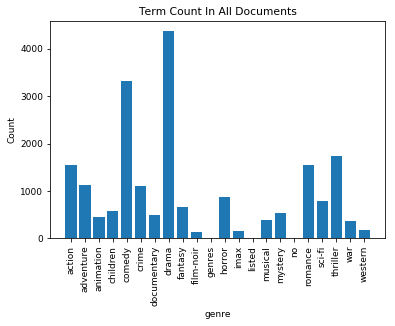

In [318]:
plt.rc('font',size=9)
plt.bar(termInDocs['genre'], termInDocs['termInDocsCount'])
#termInDocs.termInDocsCount.value_counts(sort=False).plot(kind='bar')
plt.title('Term Count In All Documents')
plt.xlabel('genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

For movie _Toy Story (1995)_, _animation_ has highest _tfidf_ value. There are a total of 447 movies that are categorized as _animation_ it is very low compared to other categories the movie belongs.

In [319]:
#Ratings
ratings = ratings[['userId', 'movieId', 'rating']]
movies_Genre = movies_ColToRow[['movieId','genre','wordsCount']]

ratings_Genre = pd.merge(ratings, movies_Genre, on='movieId', how='inner')
ratings_Genre = ratings_Genre[ratings_Genre.wordsCount != 0]

ratings_Genre['ratingDist'] = ratings_Genre['wordsCount'] / ratings_Genre['rating']

user_likes = pd.DataFrame(ratings_Genre.groupby(['userId', 'genre'], as_index = False)
                            .agg({'wordsCount':'sum', 'ratingDist': 'mean'})
                            .rename(columns={'wordsCount':'movies'})
                            )
users_likes = pd.DataFrame(ratings_Genre.groupby(['genre'], as_index = False)
                            .agg({'wordsCount':'sum', 'ratingDist': 'mean'})
                            .rename(columns={'wordsCount':'movies'})
                            )

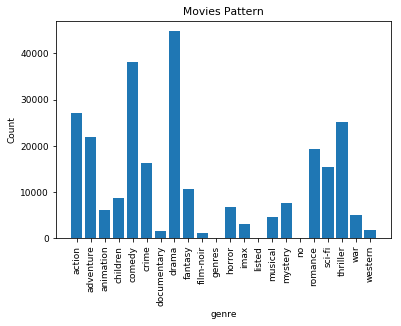

In [320]:
plt.rc('font',size=9)
plt.bar(users_likes['genre'], users_likes['movies'])
#termInDocs.termInDocsCount.value_counts(sort=False).plot(kind='bar')
plt.title('Movies Pattern')
plt.xlabel('genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Based on dataset _ratings_, we can notice most viewed movies are _drama_, followed by _action_ and _adventure_.

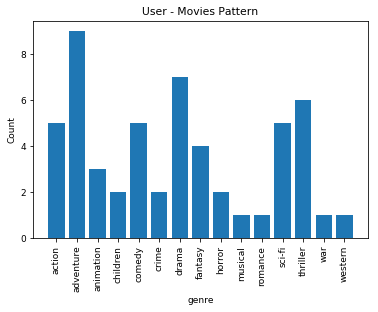

In [321]:
single_user = user_likes[user_likes['userId']==1]
plt.rc('font',size=9)
plt.bar(single_user['genre'], single_user['movies'])
#termInDocs.termInDocsCount.value_counts(sort=False).plot(kind='bar')
plt.title('User - Movies Pattern')
plt.xlabel('genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

User _one_ in the dataset likes to view more _adventure_ movies, followed by _drama_. Following shows _movies_ user has seen and there category. Users average rating is 2.55. We can assume any rating above 2.55 user liked the movie.

In [322]:
movies_titles = movies[['movieId', 'title','tokens']]
single_user = ratings[ratings['userId'] == 1]
single_user = pd.merge(single_user, movies_titles, on='movieId', how='inner')
single_user

,userId,movieId,rating,title,tokens
0,1,31,2.5,Dangerous Minds (1995),[drama]
1,1,1029,3.0,Dumbo (1941),"[animation, children, drama, musical]"
2,1,1061,3.0,Sleepers (1996),[thriller]
3,1,1129,2.0,Escape from New York (1981),"[action, adventure, sci-fi, thriller]"
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),[drama]
5,1,1263,2.0,"Deer Hunter, The (1978)","[drama, war]"
6,1,1287,2.0,Ben-Hur (1959),"[action, adventure, drama]"
7,1,1293,2.0,Gandhi (1982),[drama]
8,1,1339,3.5,Dracula (Bram Stoker's Dracula) (1992),"[fantasy, horror, romance, thriller]"
9,1,1343,2.0,Cape Fear (1991),[thriller]


In [323]:
single_user['rating'].mean()

2.55

#### Cosine Similarity

In [324]:
movies_RowToCol = movies_RowToCol.drop('movieId',  axis=1)
movies_RowToCol = movies_RowToCol.reset_index(drop=True)
similarityDf = pd.DataFrame(cosine_similarity(movies_RowToCol))
user_Recommendation = movieRecommendation(ratings, movies, similarityDf, 'cosine')
user_Recommendation[user_Recommendation['userId']==1].sample(frac=0.50, random_state=345).head(10)

,userId,watched,watchedMovieId,recommendation,recommendationId,similarity,genres
12,1,"French Connection, The (1971)",1515,State of Grace (1990),5847,0.804984,Crime|Drama|Thriller
2,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,American Me (1992),4434,1.000000,Drama
5,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Albatross (2011),7973,1.000000,Drama
8,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Fearless (1993),397,1.000000,Drama
21,1,Blazing Saddles (1974),2925,"Davy Crockett, King of the Wild Frontier (1955)",812,0.857983,Adventure|Western
14,1,"French Connection, The (1971)",1515,Infernal Affairs (Mou gaan dou) (2002),5303,0.804984,Crime|Drama|Thriller
6,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Jubilee (1977),4657,1.000000,Drama
17,1,"French Connection, The (1971)",1515,Bad Boys (1983),5801,0.804984,Crime|Drama|Thriller
0,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Glengarry Glen Ross (1992),886,1.000000,Drama
20,1,Blazing Saddles (1974),2925,Pat Garrett and Billy the Kid (1973),5268,0.969346,Western


#### Pearson Correlation Similarity

In [325]:
movies_RowToCol_T = movies_RowToCol.T
similarityDf = movies_RowToCol_T.corr(method='pearson')
user_Recommendation = movieRecommendation(ratings, movies, similarityDf, 'pearson')
user_Recommendation[user_Recommendation['userId']==1].sample(frac=0.50, random_state=345).head(10)

,userId,watched,watchedMovieId,recommendation,recommendationId,similarity,genres
5,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,In Praise of Older Women (1978),5793,1.000000,Drama
2,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Clara's Heart (1988),2967,1.000000,Drama
14,1,Sleepers (1996),859,Blink (1994),372,1.000000,Thriller
6,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,"Shop on Main Street, The (Obchod na korze) (1965)",3759,1.000000,Drama
12,1,"French Connection, The (1971)",1515,Max Payne (2008),7059,0.971413,Action|Crime|Drama|Thriller
17,1,Sleepers (1996),859,White Sands (1992),3046,0.911124,Drama|Thriller
0,1,"Gods Must Be Crazy, The (1980)",1708,Fanboys (2009),7224,0.950054,Adventure|Comedy|Drama
18,1,Sleepers (1996),859,Europa (Zentropa) (1991),4901,0.911124,Drama|Thriller
7,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Shakespeare-Wallah (1965),8156,1.000000,Drama
1,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Day of Wrath (Vredens dag) (1943),5692,1.000000,Drama


#### Euclidean Distance Similarity

In [326]:
similarityDf = pd.DataFrame(euclidean_distances(movies_RowToCol))
user_Recommendation = movieRecommendation(ratings, movies, similarityDf, 'euclidean')
user_Recommendation[user_Recommendation['userId']==1].sample(frac=0.40, random_state=345).head(10)

,userId,watched,watchedMovieId,recommendation,recommendationId,similarity,genres
49,1,Sleepers (1996),859,Night of the Demons (1988),5572,1.247670,Horror
217,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Tom and Huck (1995),7,0.816898,Adventure|Children
40,1,Sleepers (1996),859,Observe and Report (2009),7197,0.847932,Action|Comedy
144,1,Blazing Saddles (1974),2925,"Funeral, The (1996)",898,1.018598,Crime|Drama
60,1,Dumbo (1941),833,"Uninvited, The (1944)",6143,0.816808,Horror|Mystery|Romance
106,1,Blazing Saddles (1974),2925,"New Daughter, The (2009)",7772,1.090873,Horror|Thriller
65,1,Dumbo (1941),833,Sleep Dealer (2008),7395,1.202516,Sci-Fi
9,1,Sleepers (1996),859,"Black Cat, White Cat (Crna macka, beli macor) ...",2274,0.847932,Comedy|Romance
127,1,Blazing Saddles (1974),2925,"Rules of Attraction, The (2002)",4256,0.916945,Comedy|Drama|Romance|Thriller
212,1,"Gods Must Be Crazy, The (1980)",1708,On Dangerous Ground (1952),6482,0.858059,Crime|Drama|Film-Noir


Euclidean distance similarity, filtering does not generate correct results because way it is calculated. 

$\sqrt{{(x_1 - y_1)}^2 + {(x_2 - y_2)}^2}$

If a pair does not have values for $y_1$, $x_2$ and $y_2$ still they are related due to the positive value generated by the formula. To fix this, we may normalize the data.

We will be normalizing the data by dividing entire dataset by sum of the _tfidf_ values of the whole dataset.

In [327]:
#### Normalization

In [328]:
movies_normalize = l1_normalize(movies_RowToCol) 

Calculate Euclidean distances similarity once again.

In [329]:
similarityDf = pd.DataFrame(euclidean_distances(movies_normalize))
user_Recommendation = movieRecommendation(ratings, movies, similarityDf, 'euclideanNormal')
user_Recommendation[user_Recommendation['userId']==1].sample(frac=0.40, random_state=345).head(10)

,userId,watched,watchedMovieId,recommendation,recommendationId,similarity,genres
391,1,Dumbo (1941),833,"Sacrament, The (2013)",8655,0.000129,Horror|Thriller
360,1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),931,Wonder Woman (2009),8514,0.000095,Action|Adventure|Animation|Fantasy
482,1,Dumbo (1941),833,Bowfinger (1999),2218,0.000110,Comedy
180,1,"French Connection, The (1971)",1515,For Richer or Poorer (1997),1351,0.000098,Comedy
677,1,Blazing Saddles (1974),2925,Josie and the Pussycats (2001),3382,0.000137,Comedy
119,1,Sleepers (1996),859,Chasing Papi (a.k.a. Papi Chulo) (2003),4565,0.000130,Comedy
497,1,"Gods Must Be Crazy, The (1980)",1708,"Mirror Has Two Faces, The (1996)",1097,0.000083,Comedy|Drama|Romance
144,1,"French Connection, The (1971)",1515,'Salem's Lot (2004),5938,0.000088,Drama|Horror|Mystery|Thriller
238,1,Tron (1982),1665,"Animal, The (2001)",3439,0.000106,Comedy
672,1,Blazing Saddles (1974),2925,"Illusionist, The (2006)",6505,0.000155,Drama|Fantasy|Mystery|Romance


#### Conclusion

- Even though distance has reduced, but it still does not generate a proper recommendation. For content-based recommendation system, Euclidean distance similarity measure is not suitable.

- Pearson Correlation and Cosine similarity methods yield better results.

#### References

- https://grouplens.org/datasets/movielens/
- http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
- http://www.tfidf.com/
- https://github.com/viyatgandhi/content-based-recommendation-system
- https://cmry.github.io/notes/euclidean-v-cosine 